In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

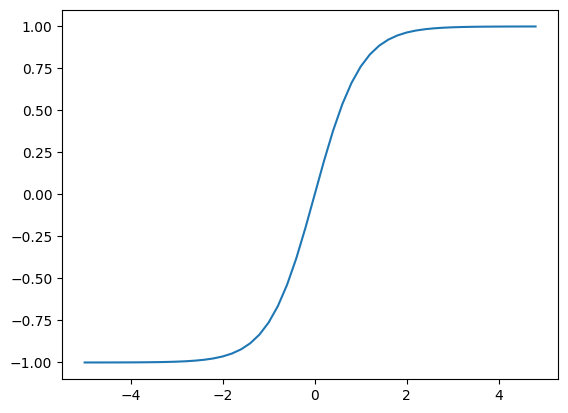

In [2]:
xs = np.arange(-5,5,0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)

In [3]:
''''Credit to Andrej Karpathy for the graphic visual'''


from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

In [4]:
import math

class Node:
    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.prev = set(children)
        self.op = operation
        self.label = label

     # Checking if the other is an instance of Node
    def wrap(self, other):

        if isinstance(other, Node):
            other = other
        else:
            other = Node(other)
        return other


    def __add__(self, other):
        other = self.wrap(other)

        out = Node(self.data + other.data, (self, other), '+')

        def back_prop():
            # accumulating the gradients for instances of the
            # same node and not overwriting
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        # Storing the function in the backward
        out._backward = back_prop
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = self.wrap(other)
        out = Node(self.data * other.data, (self, other), '*')

        def back_prop():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        # Storing the function in the backward
        out._backward = back_prop

        return out


    def __pow__(self, other):
        # Supporting integers and float values
        assert isinstance(other, (int, float))

        out = Node(self.data**other, (self,), f'pow of {other}')

        '''
        Find the chainrule for the value that is raised
        to the power of other, where other could be any number (ex: -1)
        where the power is to the power of some constant
        '''
        def back_prop():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = back_prop
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def relu(self):
        x = self.data
        # Definition of ReLu
        relu = max(0, x)
        out = Node(relu, (self, ), 'reLu')

        def back():
            if out.data > 0:
                self.grad += out.grad
            else:
                self.grad += 0
        # Storing the function in the backward
        out._backward = back

        return out

    def tanh(self):
        x = self.data
        # Definition of tanh
        tan = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Node(tan, (self, ), 'tanh')

        def back():
            self.grad += (1 - tan**2) * out.grad
        # Storing the function in the backward
        out._backward = back

        return out

    def backward(self):
        # Topological sort
        top = []
        seen = set()

        # Recursively build the topological sort
        def build_topo(v):
            if v not in seen:
                seen.add(v)
                for child in v.prev:
                    build_topo(child)
                top.append(v)
        build_topo(self)
        # Starting with the root node being 1
        self.grad = 1.0

        # Starting from the root node and going backwards
        for node in reversed(top):
            node._backward()

    # Redirecting the operations
    # Example other + self, other * self, etc.
    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1



    # For pritning the node value, the children, and the operation
    def __repr__(self):
        return f"Node(data={self.data})"


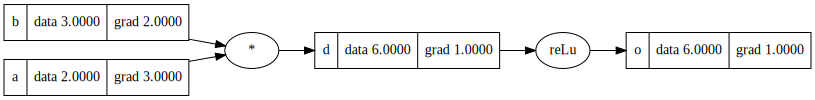

In [5]:
a = Node(2.0, label='a')
b = Node(3.0, label='b')
d = a * b; d.label = 'd'
o = d.relu(); o.label = 'o'
o.backward()
draw_dot(o)

PyTorch

In [6]:
a = torch.Tensor([2.0]).double(); a.requires_grad = True
b = torch.Tensor([3.0]).double(); b.requires_grad = True
d = a * b; d.label = 'd'
o = torch.relu(d); o.label = 'o'
o.backward()


print('output',o.item())
print('---')
print('a', a.grad.item())
print('b', b.grad.item())

output 6.0
---
a 3.0
b 2.0


------------------------------

In [7]:
#Inputs
input1 = Node(2.0, label='input1')
input2 = Node(0.0, label='input2')

# Weights
weight1 = Node(-2.8, label='weight1')
weight2 = Node(5.38, label='weight2')

# Bias
bias = Node(6.8813735870195432, label='bias')

# input1 * weight1 + input2 * weight2 + b
in1w1 = input1*weight1; in1w1.label = 'in1*w1'
in2w2 = input2*weight2; in2w2.label = 'in2*w2'

in1w1in2w2 = in1w1 + in2w2; in1w1in2w2.label = 'in1*w1 + in2*w2'
nueron = in1w1in2w2 + bias; nueron.label = 'n'
# Output
output = nueron.tanh(); output.label = 'output'


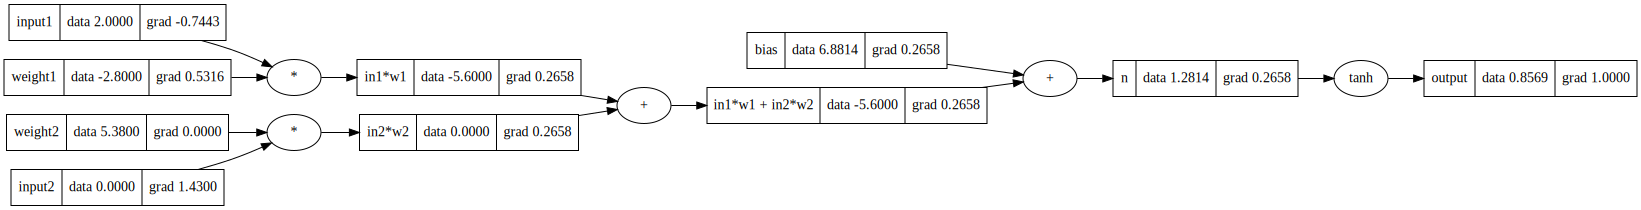

In [8]:
output.backward()
draw_dot(output)

PyTorch

In [9]:
input1 = torch.Tensor([2.0]).double(); input1.requires_grad = True
input2 = torch.Tensor([0.0]).double(); input2.requires_grad = True
weight1 = torch.Tensor([-2.8]).double(); weight1.requires_grad = True
weight2 = torch.Tensor([5.38]).double(); weight2.requires_grad = True
bias = torch.Tensor([6.8813735870195432]).double(); bias.requires_grad = True
nueron = input1*weight1 + input2*weight2 + bias
output = torch.tanh(nueron)

# The data produced
print('output',output.item())
output.backward()

print('---')
print('input2', input2.grad.item())
print('weight2', weight2.grad.item())
print('input1', input1.grad.item())
print('weight1', weight1.grad.item())

output 0.8568504320101091
---
input2 1.4300435043620363
weight2 0.0
input1 -0.7442605313847686
weight1 0.5316146743281787


Neural Network class

In [10]:
import random

class Neuron:

  def __init__(self, nin):
    # Will take the number of inputs
    self.w = [Node(random.uniform(-1.0, 1.0)) for _ in range(nin)]
    # The threshold the neuron will activate
    self.b = Node(random.uniform(-1.0, 1.0))

  def __call__(self, a):
    # w * x + b
    # Doing the forward pass of the Nueron
    act = sum((wi * xi for wi, xi in zip(self.w, a)), self.b)
    # Zip creates a list of tuples

    # Passing it all through a non-linearity
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Nueron_Layer:
  def __init__(self, nin, nout):
    # A Layer is a list of nuerons
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)

    return params


x = [2.0, 3.0]
# A Layer of 3 two-dimensional neurons
n = Nueron_Layer(2, 3)
n(x)

[Node(data=0.6205785204484351),
 Node(data=0.9845324460303855),
 Node(data=0.7302570241261266)]

In [11]:
class MLP:
    def __init__(self, num_inputs, list_of_nouts):
      size_of_layers = [num_inputs] + list_of_nouts
      self.layers = [Nueron_Layer(size_of_layers[i], size_of_layers[i + 1]) for i in range(len(list_of_nouts))]

    def __call__(self, x):
      for layer in self.layers:
        x = layer(x)
      return x

    def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]


In [51]:
x = [2.0, 3.0, -4.0]
# Three inputs into 2 layers of four and one output
n = MLP(3, [4, 4, 1])
n(x)

Node(data=0.8987236023060106)

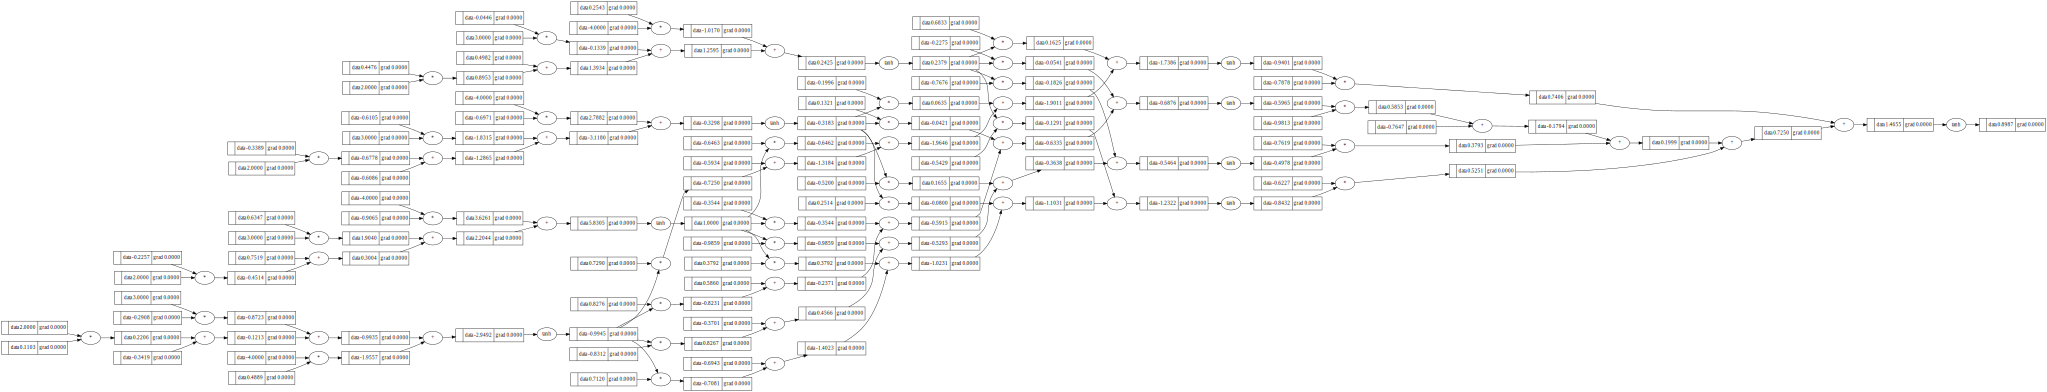

In [52]:
draw_dot(n(x))

Simple binary classifier NN

In [71]:
# Three inputs into 2 layers of four and one output
n = MLP(3, [4, 4, 1])

# 4 examples/possible inputs into the nn
# Making a binary classifier nn
data_set = [
    [2.0, 3.0, -1.0], # Output 1.0
    [3.0, -1.0, 0.5], # Output -1.0
    [0.5, 1.0, 1.0], # Output -1.0
    [1.0, 1.0, -1.0], # Output 1.0
]
desired_targets = [1.0, -1.0, -1.0, 1.0]

In [72]:
pred = [n(x) for x in data_set]
pred

[Node(data=-0.7155904270904789),
 Node(data=0.46716645179773625),
 Node(data=-0.6564473632408483),
 Node(data=-0.28837228468021614)]

In [73]:
# Creating the mean squared error loss and getting individual loss components
[(yout - ygt)**2 for ygt, yout in zip(desired_targets, pred)]

[Node(data=2.9432505135244917),
 Node(data=2.1525773972807594),
 Node(data=0.11802841422416564),
 Node(data=1.65990314393212)]

In [74]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(desired_targets, pred))
loss

Node(data=6.873759468961538)

In [75]:
loss.backward()

In [76]:
n.layers[0].neurons[0].w[0].grad

1.295419314174699

Tuning the weights of the NN

In [77]:
# Calculating a single number that measures the total performance of the nn
# Mean squared error loss
loss = []
for ground_truth, output in zip(desired_targets, pred):
  loss.append((ground_truth - output)**2)
# If loss is low then every one of the predicitions is equal to its target
loss

[Node(data=2.9432505135244917),
 Node(data=2.1525773972807594),
 Node(data=0.11802841422416564),
 Node(data=1.65990314393212)]

In [78]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [79]:
for k in range(1000):

  # forward pass
  ypred = [n(x) for x in data_set]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)


0 6.873759468961538
1 3.13896042565706
2 3.7253248852472534
3 4.452260007279607
4 0.3833026112891639
5 0.25665592077389077
6 0.1928238640022
7 0.1540356075367024
8 0.1279468550737541
9 0.10922696408647004
10 0.09515888018135692
11 0.08421239959777549
12 0.0754603409017818
13 0.06830845745918607
14 0.062358524194889686
15 0.05733381011867028
16 0.05303612104639494
17 0.04931984566721003
18 0.04607564332145214
19 0.04321984121463654
20 0.040687340025259235
21 0.038426745525121916
22 0.03639695264442361
23 0.03456470091846509
24 0.03290279399470336
25 0.031388782109529924
26 0.030003973096192016
27 0.02873268028617438
28 0.027561643733227285
29 0.026479579947828725
30 0.02547682808682286
31 0.024545069357570247
32 0.02367710257625956
33 0.022866663212238406
34 0.022108276410930636
35 0.02139713678896245
36 0.020729009488542494
37 0.020100148237024308
38 0.01950722710230563
39 0.018947283349994258
40 0.018417669354348742
41 0.017916011935181265
42 0.01744017781861982
43 0.01698824417387264

In [80]:
ypred

[Node(data=0.9872392893408687),
 Node(data=-0.9877553655921116),
 Node(data=-0.9877353490133436),
 Node(data=0.9895971474235462)]